# LightGBM Hello World Example

In this notebook, we are going to mention Microsoft LightGBM framework on a simple data set. This includes both preprocessing steps and modelling parts. You may change the source data set and run this notebook again.

### Prerequisites

You need to install these packages by running the following command

pip install pandas numpy lightgbm graphviz matplotlib

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

To plot built decision tree you need to download graphviz from the following link

https://graphviz.gitlab.io/_pages/Download/Download_windows.html

You will specify the installed path in the following block. If you haven't installed graphviz, please set plotTree variable to False

In [2]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin' #be sure where graphviz installed

In [3]:
is_regression = False #set this True to run classification
plotTree = True #if you haven't installed graphviz set this to False

We are going to work on playing golf decision data set.

You can find the raw data set here: https://github.com/serengil/decision-trees-for-ml/tree/master/dataset

In [4]:
dataset = pd.read_csv('C:/Users/IS96273/Desktop/decision tree/dataset/golf2.txt')

In [5]:
dataset.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,85,85,Weak,No
1,Sunny,80,90,Strong,No
2,Overcast,83,78,Weak,Yes
3,Rain,70,96,Weak,Yes
4,Rain,68,80,Weak,Yes


As seen loaded data set includes both continuous and string features

### Label encoding

LightGBM framework expects to convert categorical features to integer before constructing the dataset. That's why, we are going to apply label encoding to categorical features

Ref: https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

features = []; categorical_features = []

num_of_rows = dataset.shape[0]
num_of_columns = dataset.shape[1]
num_of_classes = 1 #default value is 1 for regression. we will update this for classification.

for i in range(0, num_of_columns):
    column_name = dataset.columns[i]
    column_type = dataset[column_name].dtypes
    
    if i != num_of_columns - 1: #skip target
        features.append(column_name)
    
    if column_type == 'object':
        #encode with sklearn
        le.fit(dataset[column_name])
        feature_classes = list(le.classes_)
        #print(feature_classes)
        
        encoded_feature = le.transform(dataset[column_name])
        dataset[column_name] = pd.DataFrame(encoded_feature)
        
        #encode with manually
        """feature_classes = dataset[column_name].unique()
        
        for j in range(len(feature_classes)):
            feature_class = feature_classes[j]
            print(feature_class," -> ",j,", ",end='')
                        
            dataset[column_name] = dataset[column_name].replace(feature_class, str(j))"""
        
        if i != num_of_columns - 1: #skip target
            categorical_features.append(column_name)
        
        if is_regression == False and i == num_of_columns - 1:
            num_of_classes = len(feature_classes)

In [7]:
print("num_of_classes: ",num_of_classes)
print("features: ",features)
print("categorical features: ",categorical_features)

num_of_classes:  2
features:  ['Outlook', 'Temp.', 'Humidity', 'Wind']
categorical features:  ['Outlook', 'Wind']


In [8]:
print("encoded dataset")
dataset.head()

encoded dataset


,Outlook,Temp.,Humidity,Wind,Decision
0,2,85,85,1,0
1,2,80,90,0,0
2,0,83,78,1,1
3,1,70,96,1,1
4,1,68,80,1,1


In [9]:
target_name = dataset.columns[num_of_columns - 1] #target is the final column at the right on data set

y_train = dataset[target_name].values
x_train = dataset.drop(columns=[target_name]).values

print("input features:\n",x_train)
print("--------------------")
print("output:\n",y_train)

input features:
 [[ 2 85 85  1]
 [ 2 80 90  0]
 [ 0 83 78  1]
 [ 1 70 96  1]
 [ 1 68 80  1]
 [ 1 65 70  0]
 [ 0 64 65  0]
 [ 2 72 95  1]
 [ 2 69 70  1]
 [ 1 75 80  1]
 [ 2 75 70  0]
 [ 0 72 90  0]
 [ 0 81 75  1]
 [ 1 71 80  0]]
--------------------
output:
 [0 0 1 1 1 0 1 0 1 1 1 1 1 0]


Now, we are going to create data set for LightGBM. We have already transformed categorical features to integer in previous steps. Here, we have to define categorical features. Otherwise, decision node will check instance's that feature greater than some threshold or less than the threshold. Suppose that feature is related to gender information and values are -1 for unknown, 0 for man and 1 for woman. In this case, decision node might check that gender information is greater than -1. This might cause a trouble. That's why, specifying categorical features is very important.

In [10]:
lgb_train = lgb.Dataset(x_train, y_train
    ,feature_name = features
    , categorical_feature = categorical_features
)

In [11]:
params = {
    'task': 'train'
    , 'boosting_type': 'gbdt'
    , 'objective': 'regression' if is_regression == True else 'multiclass'
    , 'num_class': num_of_classes
    , 'metric': 'rmsle' if is_regression == True else 'multi_logloss'
    , 'min_data': 1
    #, 'learning_rate':0.1
    , 'verbose': -1
}

In [12]:
gbm = lgb.train(params, lgb_train, num_boost_round=50)

C:\Users\IS96273\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [13]:
predictions = gbm.predict(x_train)
print(predictions)

[[0.99674896 0.00325104]
 [0.99674896 0.00325104]
 [0.00325104 0.99674896]
 [0.00325104 0.99674896]
 [0.00325104 0.99674896]
 [0.99674896 0.00325104]
 [0.00325104 0.99674896]
 [0.99674896 0.00325104]
 [0.00325104 0.99674896]
 [0.00325104 0.99674896]
 [0.00325104 0.99674896]
 [0.00325104 0.99674896]
 [0.00325104 0.99674896]
 [0.99674896 0.00325104]]


In [14]:
for index, instance in dataset.iterrows():
    actual = instance[target_name]
    
    if is_regression == True:
        prediction = round(predictions[index])
    else: #classification
        prediction = np.argmax(predictions[index])
    
    print((index+1),". actual= ",actual,", prediction= ",prediction)

1 . actual=  0 , prediction=  0
2 . actual=  0 , prediction=  0
3 . actual=  1 , prediction=  1
4 . actual=  1 , prediction=  1
5 . actual=  1 , prediction=  1
6 . actual=  0 , prediction=  0
7 . actual=  1 , prediction=  1
8 . actual=  0 , prediction=  0
9 . actual=  1 , prediction=  1
10 . actual=  1 , prediction=  1
11 . actual=  1 , prediction=  1
12 . actual=  1 , prediction=  1
13 . actual=  1 , prediction=  1
14 . actual=  0 , prediction=  0


## Accuracy Report

In [15]:
predictions_classes = []
for i in predictions:
    if is_regression == True:
        predictions_classes.append(round(i))
    else:
        predictions_classes.append(np.argmax(i))

predictions_classes = np.array(predictions_classes)

In [16]:
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
accuracy = accuracy_score(predictions_classes, y_train)*100
print(accuracy,"%")

100.0 %


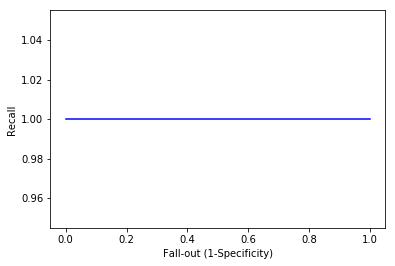

In [50]:
if is_regression == False:
    actuals_onehot = pd.get_dummies(y_train).values
    false_positive_rate, recall, thresholds = roc_curve(actuals_onehot[0], np.round(predictions)[0])
    roc_auc = auc(false_positive_rate, recall)
    
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')

    plt.show()

## Visualization

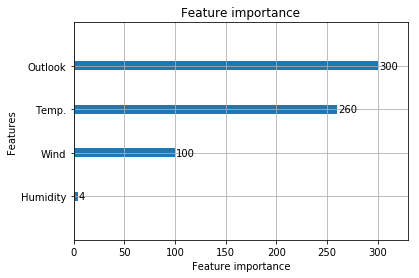

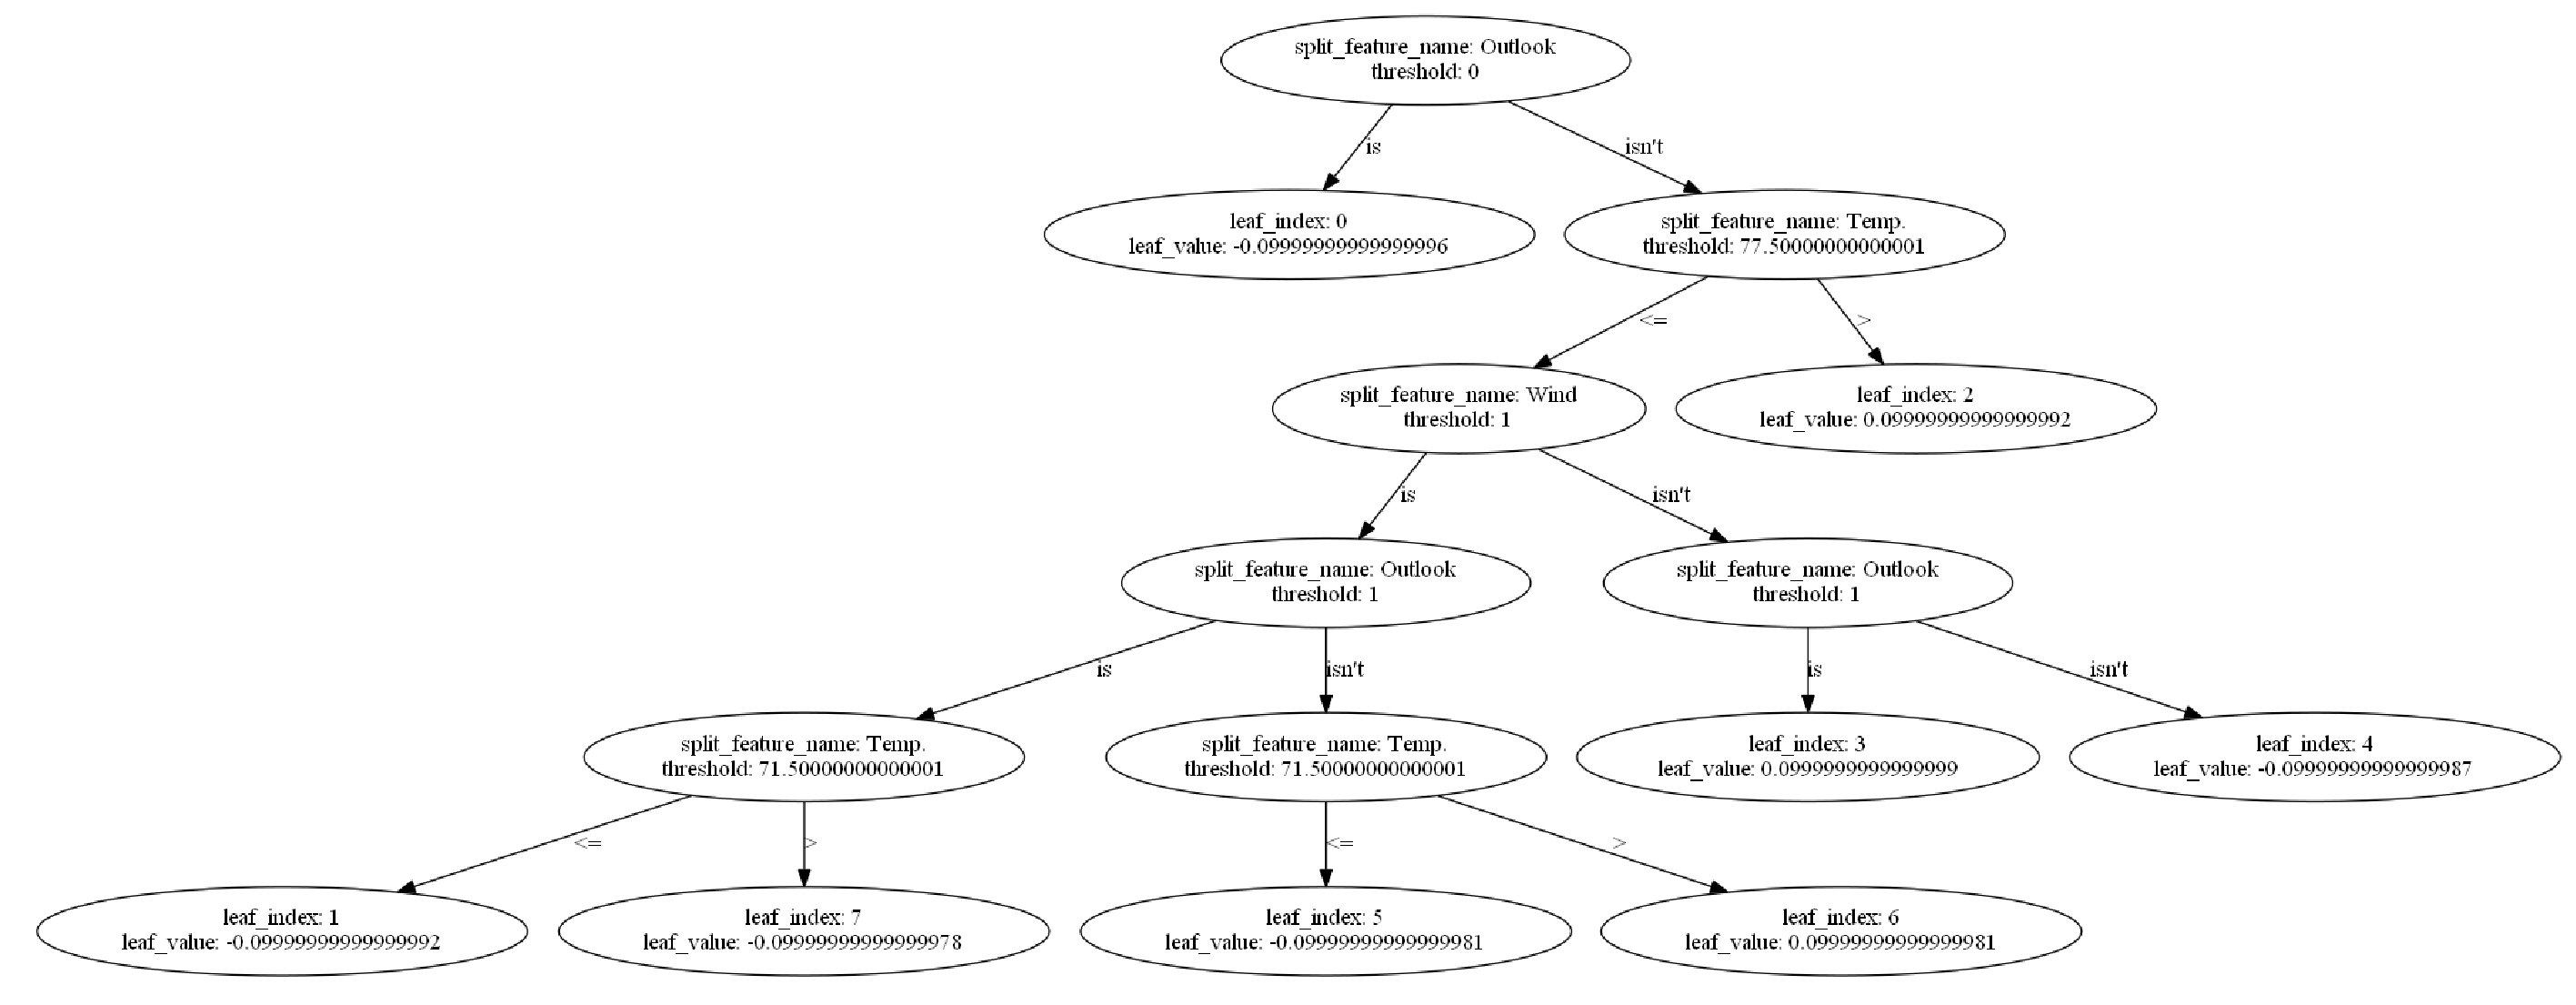

In [51]:
if plotTree == True:
    
    ax = lgb.plot_importance(gbm, max_num_features=10)
    plt.show()
    
    fig_size = [50, 30]
    plt.rcParams["figure.figsize"] = fig_size

    ax = lgb.plot_tree(gbm)
    plt.show()